In [1]:

######################################################
### Attaching and downloading necessary packagaes ####
######################################################
# if (!requireNamespace("BiocManager", quietly = FALSE))
#     install.packages("BiocManager")
# BiocManager::version()
# library("devtools")
# devtools::install_github("broadinstitute/infercnv", force=TRUE)
# detach("package:infercnv", unload=T)  ### package infercnv_1.15.3  seems to work fine
library(infercnv)
#### loading packages and others 
library("Seurat")
library("tidyverse")
#remotes::install_github("mojaveazure/seurat-disk")
library("SeuratDisk")
#install.packages("ggplot2")
library(ggplot2)
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
library(DoubletFinder)
library(dplyr)
library(tidyverse)
library(ggpubr)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, saveRDS


Loading Seurat v5 beta version 
To maintain compatibility with previous workflows, new Seurat objects will use the previous object structure by default
To use new Seurat v5 assays: Please run: options(Seurat.object.assay.version = 'v5')

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter(

In [2]:
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326_81-72-75-4_filtered_feature_bc_matrix.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_distribution.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features <- plot1 + plot2
SCAF3163_features
dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
dev.off()
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
SCAF3163_features_filtered <- plot1 + plot2
SCAF3163_features_filtered
dev.off()
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/most_variable.jpg", width = 3000, height = 2000, res=300)
plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
SCAF3163_filterd_variable <- plot1 + plot2
SCAF3163_filterd_variable
dev.off()
## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/difference_regressed_cell_cyle_SCAF2326.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
DimPlot(dat_seurat_obj_filtered)
dev.off()


## step 11. Run PCA to reduce the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/elbow.jpg", width = 3000, height = 2000, res=300)
ElbowPlot(dat_seurat_obj_filtered)
dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "pca")
dev.off()

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

png 
  2

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


png 
  2

Warning message:
“The following arguments are not used: nselect”
When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”


png 
  2

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TYMS, HMGB2, UBE2C, TOP2A, TPX2, MCM2, CKS1B, NUSAP1, CCNB2, CDC20 
	   CKS2, FEN1, NASP, PCNA, UHRF1, KIF23, CDC45, SLBP, BIRC5, MCM4 
	   RRM1, CDCA8, GMNN, CENPA, MKI67, RRM2, CDC6, UNG, MCM5, CDK1 
Negative:  G2E3, GAS2L3, LBR, CTCF, CASP8AP2, CDC25C, RANGAP1, KIF20B, WDR76, CENPE 
	   TACC3, POLD3, BRIP1, CCNE2, RPA2, CDCA

png 
  2

PC_ 1 
Positive:  STMN1, CKB, HBS1L, KRT8, CDKN2A, MAGEA4, EEF1A2, CST7, SPOCK2, CD7 
	   KRT18, MYCN, TRBC2, TUBB2B, CXCR3, CNN3, IL2RB, CD27, GZMA, LTB 
	   SH2D2A, PRAME, TFF3, TYMS, PTTG1, TRBC1, MDK, NMU, HIST1H1C, HMGB2 
Negative:  IFI30, AIF1, TYROBP, CD14, SERPINA1, PLAUR, FCER1G, CST3, SPI1, LYZ 
	   CYBB, SLC11A1, CD68, HLA-DRA, S100A9, CTSS, C5AR1, LST1, MS4A7, FCGR3A 
	   PSAP, BCL2A1, FCN1, NPC2, SOD2, CTSB, TYMP, NCF2, S100A8, HLA-DRB1 
PC_ 2 
Positive:  DUSP2, CST7, CD7, LTB, SPOCK2, TRBC2, GZMA, IL2RB, RGS1, CXCR3 
	   CD27, SH2D2A, CCL5, DUSP4, TRBC1, CD69, CD74, CTSW, NKG7, CD6 
	   APOBEC3G, BATF, GBP5, TAGAP, PRF1, TIGIT, BIRC3, TRAC, CTLA4, BTG2 
Negative:  BGN, IGFBP7, COL6A2, COL1A2, CALD1, SPARC, COL1A1, COL3A1, C1S, MGP 
	   COL4A2, AEBP1, PCOLCE, COL6A1, COL6A3, NNMT, CPE, COL4A1, SERPING1, FSTL1 
	   MYL9, COL18A1, MXRA8, IGFBP4, COL5A2, LAMA4, A2M, FN1, CFH, C1R 
PC_ 3 
Positive:  CST7, CD7, DUSP2, IL2RB, SPOCK2, TRBC2, LTB, DUSP4, GZMA, SH2D2A 
	   CD27, CX

png 
  2

png 
  2

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2399
Number of edges: 75046

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8764
Number of communities: 17
Elapsed time: 0 seconds


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.0663570,0.062028806,-0.089463888,S,SCLC,0.151492694,0,0
AAACCTGAGGATTCGG-1,SCLC,3248,1432,3.0480296,-0.054138074,-0.065433658,G1,SCLC,0.011295584,4,4
AAACCTGCATAACCTG-1,SCLC,3244,658,2.5893958,-0.059976841,-0.026566814,G1,SCLC,-0.033410027,5,5
AAACCTGCATTTCACT-1,SCLC,4083,1850,2.4246877,-0.022671791,-0.076830556,G1,SCLC,0.054158765,11,11
AAACCTGGTGACTCAT-1,SCLC,7704,2241,3.3878505,-0.062310283,-0.021173250,G1,SCLC,-0.041137033,1,1
AAACCTGGTGGTAACG-1,SCLC,2060,1050,3.4951456,0.017646544,-0.166250278,S,SCLC,0.183896823,1,1
AAACCTGGTTCGTTGA-1,SCLC,5017,1862,2.7307156,-0.035989169,-0.040630124,G1,SCLC,0.004640955,1,1
AAACCTGTCACCACCT-1,SCLC,12246,1754,1.6168545,-0.056421841,-0.090467610,G1,SCLC,0.034045769,10,10
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.6073992,0.070506773,0.003091556,S,SCLC,0.067415218,8,8


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
12:22:21 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

12:22:21 Read 2399 rows and found 20 numeric columns

12:22:21 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

12:22:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

12:22:21 Writing NN index file to t

png 
  2

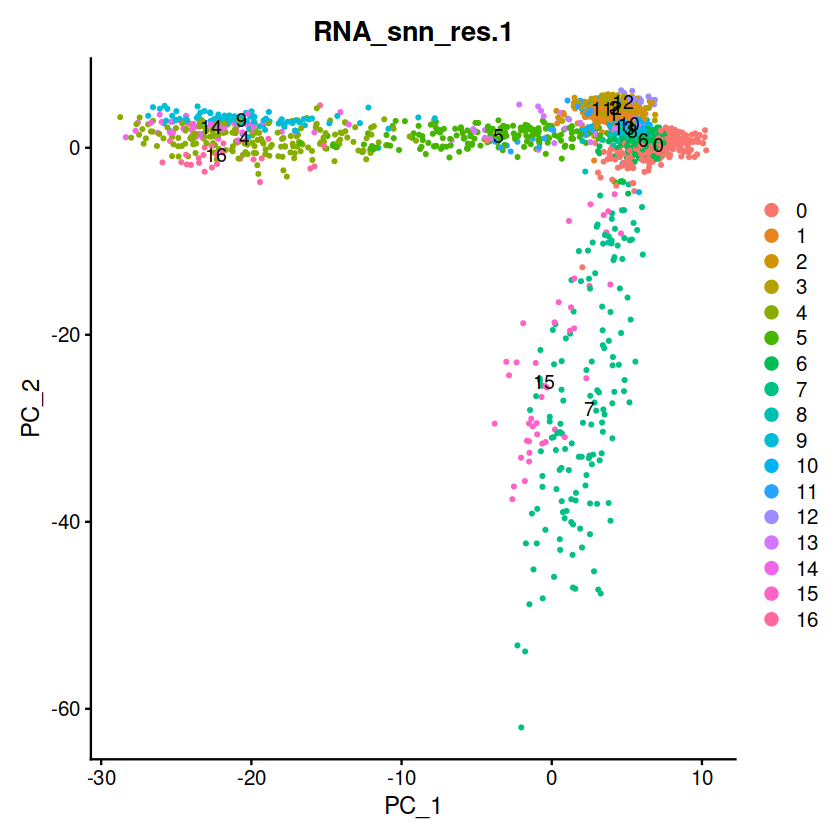

In [3]:
## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution = 1) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
View(dat_seurat_obj_filtered@meta.data)
DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.1", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.9", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.7", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.5", label=TRUE)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

## choosing best cluster using Dimplot, as above
Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.1" ## setting increased resolution of cluster 
dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/UMAP.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
dev.off()

png 
  2

png 
  2

Loading required package: fields

Loading required package: spam

Spam version 2.9-1 (2022-08-07) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL


png 
  2

[1] "Creating 800 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.01_167,DF.classifications_0.25_0.01_167
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.0663570,0.062028806,-0.089463888,S,SCLC,0.151492694,0,0,0.06250,Singlet
AAACCTGAGGATTCGG-1,SCLC,3248,1432,3.0480296,-0.054138074,-0.065433658,G1,SCLC,0.011295584,4,4,0.25000,Doublet
AAACCTGCATAACCTG-1,SCLC,3244,658,2.5893958,-0.059976841,-0.026566814,G1,SCLC,-0.033410027,5,5,0.03125,Singlet
AAACCTGCATTTCACT-1,SCLC,4083,1850,2.4246877,-0.022671791,-0.076830556,G1,SCLC,0.054158765,11,11,0.09375,Singlet
AAACCTGGTGACTCAT-1,SCLC,7704,2241,3.3878505,-0.062310283,-0.021173250,G1,SCLC,-0.041137033,1,1,0.06250,Singlet
AAACCTGGTGGTAACG-1,SCLC,2060,1050,3.4951456,0.017646544,-0.166250278,S,SCLC,0.183896823,1,1,0.03125,Singlet
AAACCTGGTTCGTTGA-1,SCLC,5017,1862,2.7307156,-0.035989169,-0.040630124,G1,SCLC,0.004640955,1,1,0.06250,Singlet
AAACCTGTCACCACCT-1,SCLC,12246,1754,1.6168545,-0.056421841,-0.090467610,G1,SCLC,0.034045769,10,10,0.25000,Doublet
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.6073992,0.070506773,0.003091556,S,SCLC,0.067415218,8,8,0.03125,Singlet


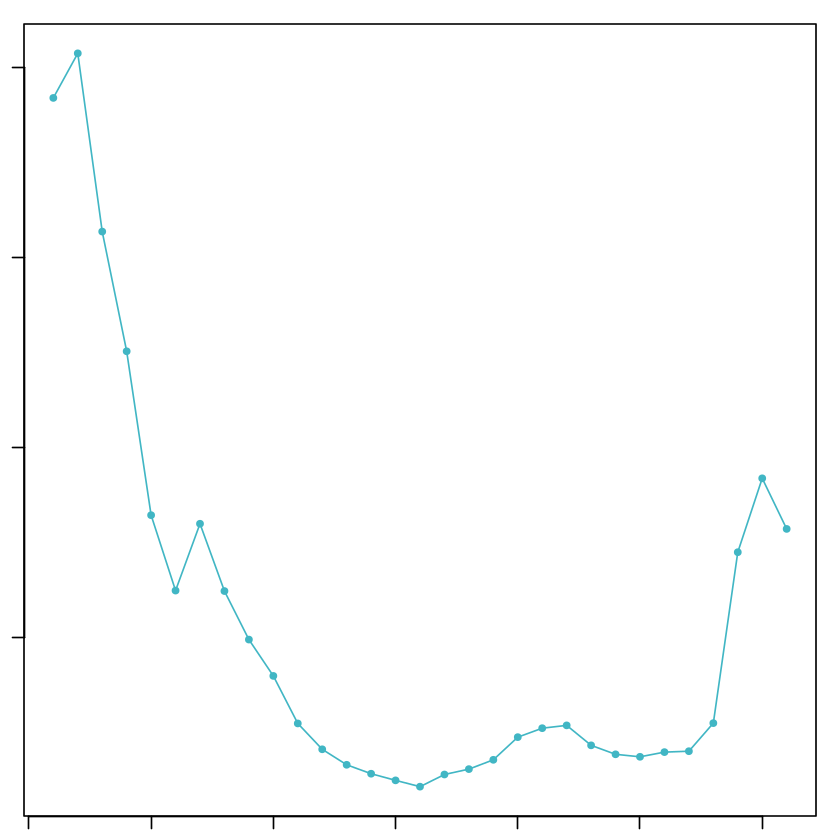

In [4]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/cell_cycle.jpg", width = 2000, height = 1200, res=300)
pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
pl <- pl + geom_bar(stat="identity", position ="fill")
pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
                     position=position_fill(vjust=0.5), colour="black", size =3)

pl <- pl + theme_minimal()
#pl <- pl + labs(title ="Cell cycle score for SCAF2229")
#pl <- pl + labs(subtitle ="plot")
pl <- pl + labs(caption ="Cell cycle score for SCAF2326")
pl <- pl  + labs(x ="Cluster", y = "Percentage")
pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
pl
dev.off()

### cell cycle plot without percent label
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/cell_cycle_SCAF2326.jpg", width = 2000, height = 1200, res=300)
ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
  geom_col()
dev.off()
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/optimal_k.jpg", width = 3000, height = 2000, res=300)
ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
geom_point()+
geom_line()
dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [5]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                       "nCount_RNA"                      
 [3] "nFeature_RNA"                     "percent.mt"                      
 [5] "S.Score"                          "G2M.Score"                       
 [7] "Phase"                            "old.ident"                       
 [9] "CC.Difference"                    "RNA_snn_res.1"                   
[11] "seurat_clusters"                  "pANN_0.25_0.01_167"              
[13] "DF.classifications_0.25_0.01_167"

[1] 182

[1] 167

In [6]:
### visulaize the doublets 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_167")
dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.01_167"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_145")
#dev.off()


### plotting the doublet removed dataset with cluster info 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/without_doublets.jpg", width = 3000, height = 2000, res=300)
DimPlot(data.filt, reduction = "umap", label = TRUE)
dev.off()





png 
  2

png 
  2

In [7]:
## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_positive_marker_gene.csv")
# saving markers genes for a defined crieria
sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
write.csv(sub_df, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_positive_marker_gene_significant.csv")
# plotting the marker gene 
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/top5_markers.jpg", width = 5500, height = 3300, res=300)
dat_filt.markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC) -> top5
DoHeatmap(data.filt, features = top5$gene) + NoLegend()
dev.off()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.844316e-164,3.163962,0.671,0.068,4.832478e-160,0,TUBB2B
9.803979e-175,3.125264,0.740,0.083,2.568839e-170,0,EEF1A2
5.126630e-141,4.033676,0.483,0.031,1.343280e-136,1,CCR7
4.050801e-152,3.595616,0.722,0.109,1.061391e-147,1,IL7R
3.006821e-93,4.067210,0.264,0.007,7.878472e-89,2,ZNF683
2.464459e-176,3.812774,0.639,0.040,6.457375e-172,2,CD8B
0.000000e+00,6.107374,0.834,0.013,0.000000e+00,3,FOXP3
2.288289e-214,4.740943,0.839,0.074,5.995774e-210,3,TNFRSF4
2.385405e-105,4.601614,0.370,0.018,6.250239e-101,4,RETN


png 
  2

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”
Warning message:
“The following arguments are not used: scale.factor”
Centering and scaling data matrix

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 2232 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done

Warning message:
“The

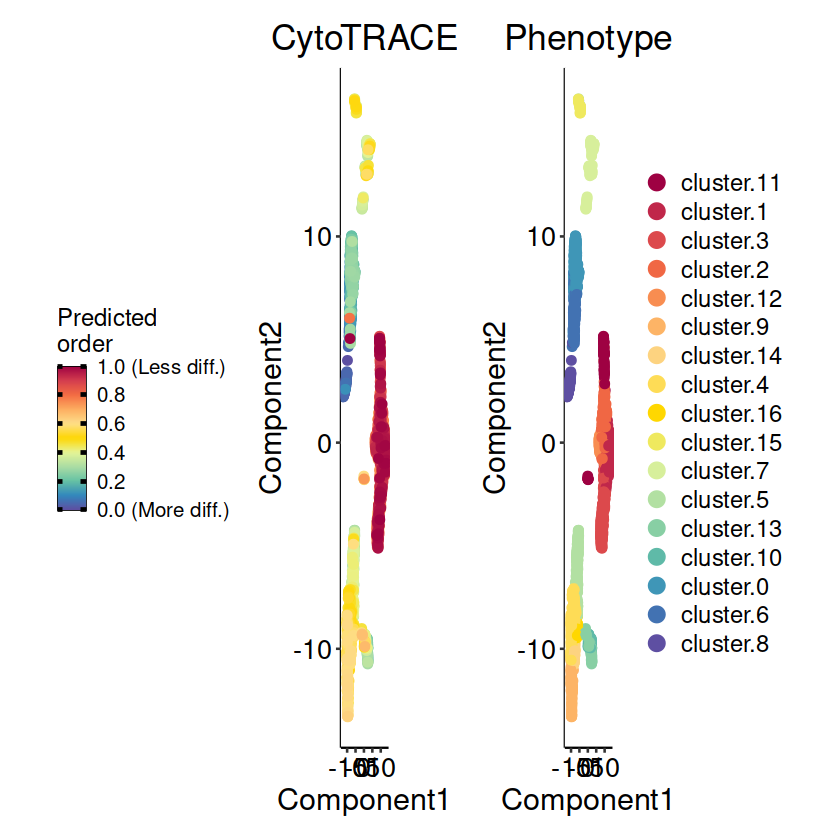

In [8]:
#### Cyotrace analysis starts from here ####
# Link - https://cytotrace.stanford.edu/
####
#install.packages("devtools")
#devtools::install_local("/data/kumarr9/CytoTRACE_0.3.3.tar.gz")
library(CytoTRACE)
#### Cyotrace needs the normalized seurat object
# mtrx should be non-negative(?) => seurat_obj should be normalized using scale.factor=1e6 instead of default (1e5)
seurat_obj <- ScaleData(data.filt, scale.factor=1e6 )
# seurat_obj <- RunPCA(seurat_obj)
# seurat_obj <- JackStraw(seurat_obj)
# seurat_obj <- ScoreJackStraw(seurat_obj)
# seurat_obj <- FindClusters(seurat_obj)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
## remove genes with 0 reads (of the genes included)
 genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')

 cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/CytoTRACE.output.data')
#### Getting NE, Non-NE gene expression within each cluster of seurat object ####

# Provide a list of genes whose expression you want to see within each cluster
sclc_ne_genes <- c("ASCL1", "BEX1", "BSN", "CELF3", "CHGA", "CHGB","CRMP1", "FAM57B", "INSM1", "KIF1A", 
                   "KIF5C", "MYT1", "RTN1", "RUNDC3A", "SCG3","SEZ6", "SH3GL2", "SYN1", "SYP", "SYT11", 
                    "SYT4", "TAGLN3" ,"TFF3", "TMSB15A", "TMSB15B")
sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")

# Use the marker genes for each cluster identified in previous steps -
#dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "neuro"
                                   )

seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_non_ne_genes),
                                   ctrl = 20,
                                   name = "non_neuro"
                                   )


In [9]:
#Getting NE expression data
gene_data <- seurat_obj@meta.data$neuro1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label


gene_data2 <- seurat_obj@meta.data$non_neuro1
cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
data_df2 <- cbind(gene_data2, cluster_info2)
data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)

## Plotting starts from here 
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, fill= factor(cluster_info))) +
  geom_violin() +
  labs(x = "Cluster", y = "Expression") + theme_minimal() + 
  ggtitle("NE gene expression by Cluster") + geom_hline(yintercept=0.00, linetype="dashed", color = "red")
ne1 <- ne + theme(legend.position = "none") ## added to remove the fill label
 non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, fill= factor(cluster_info2))) +
    geom_violin() +
    labs(x = "Cluster", y = "Expression") + theme_minimal() + 
    ggtitle("Non-NE gene expression by Cluster") + geom_hline(yintercept=0.00, linetype="dashed", color = "red")
non_ne1 <-  non_ne + theme(legend.position = "none") ## added to remove the fill label
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/NE_NonNE.jpg", width = 3000, height = 1500, res=300)
ggarrange(ne1, non_ne1, 
          ncol = 2, nrow = 1)
dev.off()

png 
  2

In [10]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_cell_cycle_regress_difference_out_resolution_1.rds")

In [11]:
####################################################################
#### Working with saved object to create InferCNV plots and so #####
####################################################################

#### trying working with seurat object ---
## trying InferCNV from the saved .rds file
SCAF2326 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_cell_cycle_regress_difference_out_resolution_1.rds")
load("/data/kumarr9/scRNA/PBMC_seu.RData")

## step 16. mergind the two seurat object 
# link - https://satijalab.org/seurat/articles/merge_vignette.html
# We are merging based on normalized one and hence added the parameters of merge.data=TRUE
SCAF2326_merged <- merge(SCAF2326, y = PBMC_seu, add.cell.ids = c("SCLC", "PBMC"), project = "SCLC",
     merge.data = TRUE)
# to see the content of merged object
# SCAF3163_merged@assays$RNA@counts
# dim(SCAF3163_merged)
# dim(SCAF3163)
# dim(PBMC_seu)

## step 17. Getting count matrix from merged dataframe
#str(SCAF3163_merged)
expr_matrix <- GetAssayData(object = SCAF2326_merged, slot = "counts", assay = "RNA")
# converting the expr_matrix which is dgCmatrix to dataframe 
expr_df <- as.data.frame(expr_matrix)
#expr_df[1:20, 1:20]
write.table(expr_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_matrix.csv", sep = "\t", row.names = TRUE, col.names = TRUE)
### creating gene order matrix for infercnv 
gene_names <- rownames(SCAF2326_merged)
### converted it to dataframe 
gene_names <- data.frame(gene_names)
## adding chromosme number, start and end to it
## read a gtf file ----
gtf_file <- read.table("/data/SCLCgenomics/rajesh/gene_version_27_cp.gtf")
matching_rows <- gtf_file[gtf_file$V5 %in% gene_names$gene_names, ]
### correcting this dataframe as given in inferCNV package
gene_df <- matching_rows %>% 
  select(V5, everything())
gene_df <- gene_df[, -5]
gene_df = gene_df[!duplicated(gene_df$V5),]
# names(gene_df)[2] <- "chr"
# names(gene_df)[3] <- "start"
# names(gene_df)[4] <- "stop"

###
write.table(gene_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_gene_order.txt", sep = "\t", row.names = FALSE, col.names = FALSE)
## getting the cluster info from the seurat object/merged object
clust_info <- SCAF2326_merged@meta.data[, "seurat_clusters", drop=F]
## making dataset what looks like or needed by the inferCNV
clust_info$cellID <- rownames(clust_info)
clust_info$clstr <- paste0('cluster.', clust_info$seurat_clusters)
clust_info_df <- clust_info[, !names(clust_info) %in% "seurat_clusters"]
write.table(clust_info_df, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_annotation.txt", sep = "\t", row.names = FALSE, col.names = FALSE)



Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.5 GiB”


In [2]:
### running Infercnv with the script and then plotting result using the code below

#Below is the code for cnv score calculation after running inferCNV for the sample RU1311AT1 using cluster 2 as ref
# Read the infercnv result tableinto a matrix format
expr <- read.table(paste0("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/infercnv.observations.txt"), header=T) %>% as.matrix()
# Scale the expression matrix by subtracting the column means and dividing by the column standard deviations
expr.scale <- scale(t(expr))
# Subtract the minimum value of each column from the scaled expression matrix
tmp1 <- sweep(expr.scale, 2, apply(expr.scale, 2, min),'-')
# Calculate the range (maximum - minimum) of each column in the scaled expression matrix
tmp2 <- apply(expr.scale, 2, max) - apply(expr.scale,2,min)
# Normalize the scaled expression matrix to the range of -1 to 1
expr_1 <- t(2*sweep(tmp1, 2, tmp2, "/")-1)
# Calculate the CNV score by summing the squared values of each column in the normalized expression matrix
cnv_score <- as.data.frame(colSums(expr_1 * expr_1))
#head(cnv_score)
#### CNV score calculation ends here #######

###################################
### CNV plot starts from here #####
###################################
### before plotting, needs some sort of processing such as doing add rownames of cell ID to dataframe and assign name CellID to this
cnv_score <- tibble::rownames_to_column(cnv_score, var = "CellID")
colnames(cnv_score)[2] ="score"
# saving this dataframe for future use, if needed
write.table(cnv_score, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_cnv_score.txt", sep = "\t", row.names=FALSE)
## Since, the two dataframe i.e. cnv score dataset and annotation dataset has similar thing in terms of cellID but in different order
## so, make them in similar order
# Read File 1 into a data frame
file1 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_cnv_score.txt", header = TRUE)

# Read File 2 into a data frame
file2 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_annotation.txt", header = TRUE)
### make copy of the annotation file, since InferCNV needs the file without header and here we are adding header for plot and so
file2_cp <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_annotation.txt", header = FALSE)
# Add headers to the data
headers <- c("CellID", "Info")
colnames(file2_cp) <- headers
# save the annotation copied file with header info
write.table(file2_cp, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/annotation_cp.txt", sep = "\t", col.names = TRUE, row.names = FALSE)

png 
  2

png 
  2

In [3]:
## Open the annotation_cp.txt file and check for the file1 and file3 has the same format of row
## in saved file change :%s/-/./g, so that file1 and file3 has same column
file3 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/annotation_cp.txt", header = TRUE)
# Merge File 1 and File 2 based on the cell ID column
merged <- merge(file1, file3, by = "CellID")

# Reorder the rows of File 1 based on the order in File 2
ordered_file1 <- merged[order(merged$CellID), ]

## save the dataframe for future use 
write.table(ordered_file1, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/cnv_score_ordered_annotation.txt", sep = "\t", row.names = FALSE)
### plotting the results ###
library(ggplot2)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_classic.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2326") +
  labs(title="",x="Cluster", y = "CNV Scores") +  theme_classic() + theme(axis.text.x = element_text(angle = 30, hjust = 1)) 
dev.off()

png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_minimal.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2326") +
  labs(title="",x="Cluster", y = "CNV Scores") + theme_minimal() + theme(axis.text.x=element_text(angle=30, hjust=1))
dev.off()

file3 <- read.table("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/annotation_cp.txt", header = TRUE)
# Merge File 1 and File 2 based on the cell ID column
merged <- merge(file1, file3, by = "CellID")

# Reorder the rows of File 1 based on the order in File 2
ordered_file1 <- merged[order(merged$CellID), ]

## save the dataframe for future use 
write.table(ordered_file1, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/cnv_score_ordered_annotation.txt", sep = "\t", row.names = FALSE)
### plotting the results ###
library(ggplot2)
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_classic.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2326") +
  labs(title="",x="Cluster", y = "CNV Scores") +  theme_classic() + theme(axis.text.x = element_text(angle = 30, hjust = 1)) 
dev.off()

png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_minimal.jpg", width = 3000, height = 2000, res=300)
ggplot(ordered_file1, aes(x=Info, y=score, fill=Info)) + 
  geom_violin(trim=FALSE)+
  geom_boxplot(width=0.1, fill="white")+ ggtitle("InferCNV estimation for SCAF2326") +
  labs(title="",x="Cluster", y = "CNV Scores") + theme_minimal() + theme(axis.text.x=element_text(angle=30, hjust=1))
dev.off()

png 
  2

png 
  2

In [14]:
## This can be done just after # step 13, after removing doublets
### cluster_profiler analysis/plot starts from here 
# load libraries
library(clusterProfiler)
library(org.Hs.eg.db)
################
logFCfilter=0.5 ## define cutoff
adjPvalFilter=0.05
Cells.markers <- FindAllMarkers(data.filt, # the Seurat obejct
only.pos = TRUE,
min.pct = 0.25,
logfc.threshold = logFCfilter)
################
Cells.markers %>%
  group_by(cluster) %>%
  top_n(n = 200, wt = abs(avg_log2FC)) -> top100
top100$cluster <- factor(top100$cluster, levels = c("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16")) ## change this to for number of clusters, this can be seen from UMAP plot 
eg = bitr(top100$gene, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")
top100 <- merge(top100, eg, by.x = "gene", by.y = "SYMBOL")
#################
cpr <- compareCluster(ENTREZID ~ cluster,
                      data = top100,
                      fun = "enrichGO",
                      OrgDb="org.Hs.eg.db"
)

## plot the result for clusterprofiler ####
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_cluster_profile.jpg", width = 4000, height = 2900, res=300)
dotplot(cpr, label_format = 100)+xlab("")+
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
  scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
  theme_linedraw()
dev.off()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(top100$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“1.61% of input gene IDs are fail to map...”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

In [17]:
##Hallmark gene set analysis within clusters ###
library(msigdbr)
msigdbr_show_species()
### retrieving only human datasets ###
#Molecular Signatures Database is a collection of annotated gene sets. It contains 8 major collections:

# H: hallmark gene sets
# C1: positional gene sets
# C2: curated gene sets
# C3: motif gene sets
# C4: computational gene sets
# C5: GO gene sets
# C6: oncogenic signatures
# C7: immunologic signatures
cp.t2g <- clusterProfiler::read.gmt("/data/kumarr9/h.all.v2022.1.Hs.symbols.gmt")
#trying running for the enrichment analysis like before:
cpr_hall <- compareCluster(gene ~ cluster,
                      data = top100,
                      fun = "enricher",
                      TERM2GENE = cp.t2g,
                      minGSSize = 0,
                      maxGSSize = 5000)

## plot the result for clusterprofiler ####
# dotplot(cpr_hall, label_format = 100)+xlab("")+
#   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
#   scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
#   theme_linedraw()

## plot the result for clusterprofiler ####
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326_hallmark.jpg", width = 4000, height = 2900, res=300)
dotplot(cpr_hall, label_format = 100)+xlab("")+
   theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))+
   scale_color_viridis_c(option = "viridis", begin = 1, end = 0)+ ### change "viridis" to either "magma" or so link - https://cran.r-project.org/web/packages/viridis/vignettes/intro-to-viridis.html
   theme_linedraw()
dev.off()

Warning message:
“'msigdbr_show_species' is deprecated.
Use 'msigdbr_species' instead.
See help("Deprecated")”


[1] "Anolis carolinensis"             "Bos taurus"                     
 [3] "Caenorhabditis elegans"          "Canis lupus familiaris"         
 [5] "Danio rerio"                     "Drosophila melanogaster"        
 [7] "Equus caballus"                  "Felis catus"                    
 [9] "Gallus gallus"                   "Homo sapiens"                   
[11] "Macaca mulatta"                  "Monodelphis domestica"          
[13] "Mus musculus"                    "Ornithorhynchus anatinus"       
[15] "Pan troglodytes"                 "Rattus norvegicus"              
[17] "Saccharomyces cerevisiae"        "Schizosaccharomyces pombe 972h-"
[19] "Sus scrofa"                      "Xenopus tropicalis"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


png 
  2

In [ ]:
## Trying getting UMAP coordinates and barcodes for scvelo analysis

In [2]:
## Getting UMAP coordinates
SCAF2326 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_cell_cycle_regress_difference_out_resolution_1.rds")
SCAF2326_coords <- SCAF2326$umap@cell.embeddings
SCAF2326_coords <- data.frame(SCAF2326_coords)
SCAF2326_coords <- tibble::rownames_to_column(SCAF2326_coords, "Barcode")
write.table(SCAF2326_coords, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_umap_coordinates.txt", sep = "\t", row.names = F, col.names = TRUE)

In [3]:
# Getting Seuart clusters
SCAF2326_cluster <- SCAF2326$seurat_clusters
SCAF2326_cluster <- data.frame(SCAF2326_cluster)
SCAF2326_cluster <- tibble::rownames_to_column(SCAF2326_cluster, "Barcode")
write.table(SCAF2326_cluster, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_clusters.txt", sep = "\t", row.names = F, col.names = TRUE)
## File has been moved to .csv from .txt

In [10]:
SCAF2326 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_cell_cycle_regress_difference_out_resolution_1.rds")
class(SCAF2326)

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

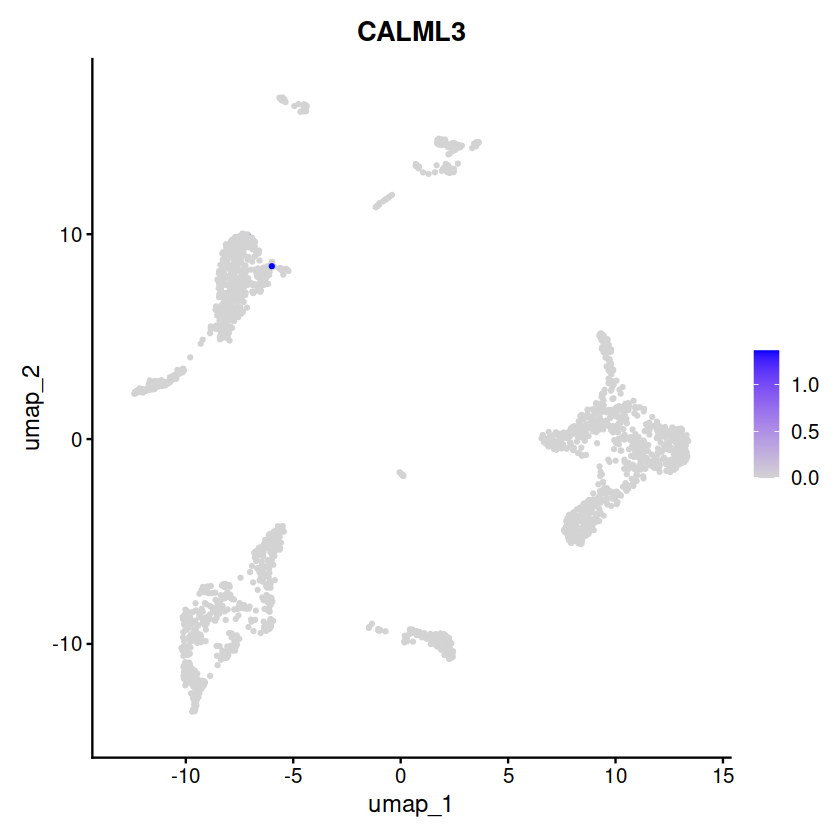

In [25]:
#FeaturePlot(SCAF2326)
DefaultAssay(SCAF2326) <- "RNA"
FeaturePlot(SCAF2326, "CALML3")

In [15]:
SCAF2326[[]]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.01_167,DF.classifications_0.25_0.01_167,neuro1,non_neuro1
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.0663570,0.062028806,-0.089463888,S,SCLC,0.151492694,0,0,0.06250,Singlet,0.051417977,-0.02918315
AAACCTGCATAACCTG-1,SCLC,3244,658,2.5893958,-0.059976841,-0.026566814,G1,SCLC,-0.033410027,5,5,0.03125,Singlet,0.074471569,0.28717677
AAACCTGCATTTCACT-1,SCLC,4083,1850,2.4246877,-0.022671791,-0.076830556,G1,SCLC,0.054158765,11,11,0.09375,Singlet,-0.101228492,-0.02556052
AAACCTGGTGACTCAT-1,SCLC,7704,2241,3.3878505,-0.062310283,-0.021173250,G1,SCLC,-0.041137033,1,1,0.06250,Singlet,-0.091507265,0.23900513
AAACCTGGTGGTAACG-1,SCLC,2060,1050,3.4951456,0.017646544,-0.166250278,S,SCLC,0.183896823,1,1,0.03125,Singlet,-0.078218817,0.35946853
AAACCTGGTTCGTTGA-1,SCLC,5017,1862,2.7307156,-0.035989169,-0.040630124,G1,SCLC,0.004640955,1,1,0.06250,Singlet,-0.103466956,0.12692335
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.6073992,0.070506773,0.003091556,S,SCLC,0.067415218,8,8,0.03125,Singlet,-0.025826358,-0.08811751
AAACGGGAGCCTCGTG-1,SCLC,2053,845,4.8222114,-0.008685183,-0.015908596,G1,SCLC,0.007223413,1,1,0.15625,Singlet,-0.067686545,0.07799662
AAACGGGGTCCAACTA-1,SCLC,4812,1830,4.2394015,-0.119019701,-0.153388476,G1,SCLC,0.034368775,1,1,0.03125,Singlet,-0.090701152,0.19200321


In [11]:
SCAF2326

An object of class Seurat 
26202 features across 2232 samples within 1 assay 
Active assay: RNA (26202 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

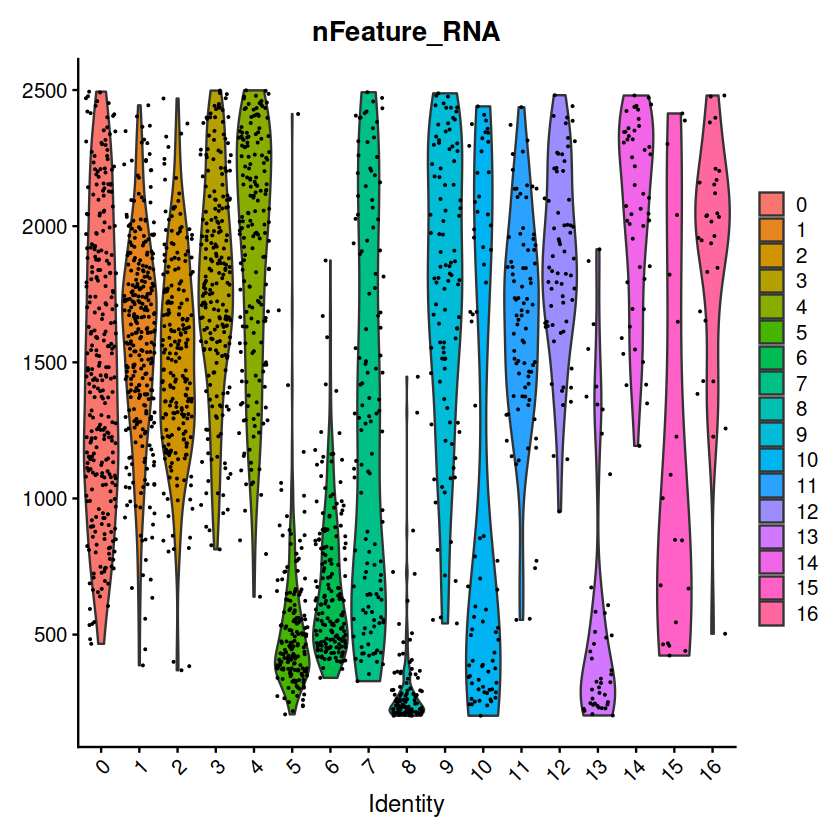

In [16]:
VlnPlot(SCAF2326, "nFeature_RNA")

In [17]:
BoxPlot(SCAF2326, "nFeature_RNA")

ERROR: Error in BoxPlot(SCAF2326, "nFeature_RNA"): could not find function "BoxPlot"


Warning message:
“The following arguments are not used: nselect”
Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: FAM64A, HN1, not searching for symbol synonyms”
Regressing out CC.Difference

Centering and scaling data matrix

Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  TYMS, HMGB2, UBE2C, TOP2A, TPX2, MCM2, CKS1B, NUSAP1, CCNB2, CDC20 
	   CKS2, FEN1, NASP, PCNA, UHRF1, KIF23, CDC45, SLBP, BIRC5, MCM4 
	   RRM1, CDCA8, GMNN, CENPA, MKI67, RRM2, CDC6, UNG, MCM5, CDK1 
Negative:  G2E3, GAS2L3, LBR, CTCF, CASP8AP2, CDC25C, RANGAP1,

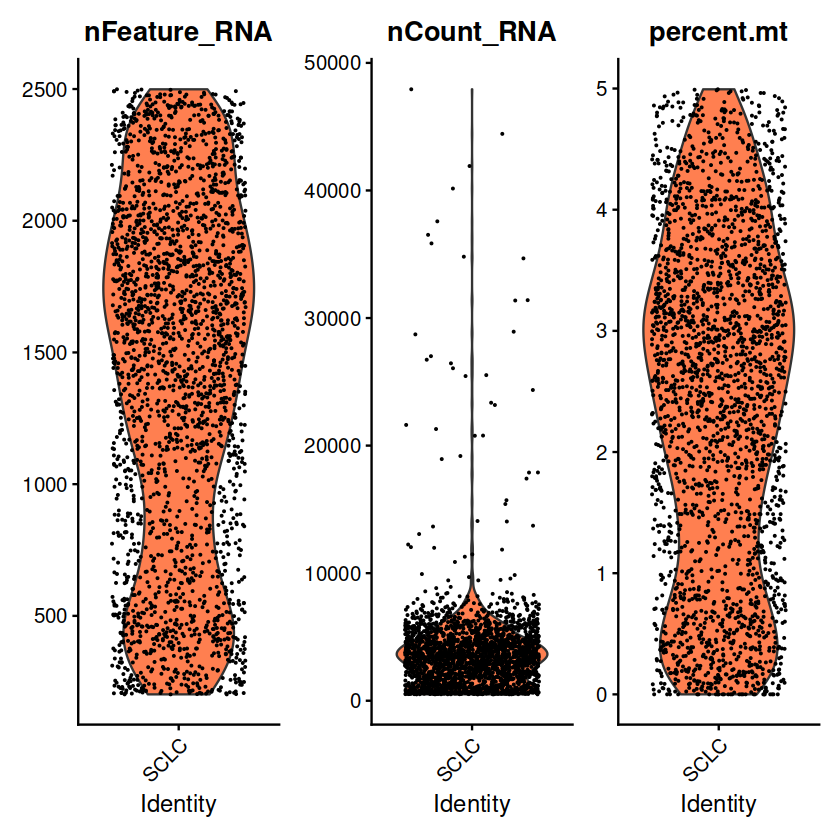

In [2]:
### studying this sample again for the purpose of stemness ####
## Step 1 . Read a scRNA file 
dat <- Read10X_h5("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326_81-72-75-4_filtered_feature_bc_matrix.h5")

## step 2 . creating seurat object with with desired cell and gene parameters and also name the project
dat_seurat_obj <- CreateSeuratObject(counts = dat, min.cells = 3, min.features = 200, project = 'SCLC')

## step 3 . Identifying mitochindrial contamination-- and adding it to seurat object -- use MT when human and mt when mouse
dat_seurat_obj[["percent.mt"]] <- PercentageFeatureSet(dat_seurat_obj, pattern = "^MT-")
#View(dat_seurat_obj@meta.data) ## to visualize the data to see mitochondrial cells contamination

## step 4. plotting the mitochondrial contamination or data distribution
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_features.jpg", width = 3000, height = 2000, res=300)
# VlnPlot(dat_seurat_obj, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
# dev.off()

## step 5. viewing data distribution before mitochondrial contamination removal
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_distribution.jpg", width = 3000, height = 2000, res=300)
# plot1 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
# plot2 <- FeatureScatter(dat_seurat_obj, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
# SCAF3163_features <- plot1 + plot2
# SCAF3163_features
# dev.off()

## step 6. Removing low quality cells and mitochondrial contamination
dat_seurat_obj_filtered <- subset(dat_seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

### just to see what number of cells left after feature selection 
#dat_seurat_obj
#dat_seurat_obj_filtered

## step 7. plots the results after filtering or filtered features
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_filtered_features.jpg", width = 3000, height = 2000, res=300)
VlnPlot(dat_seurat_obj_filtered, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3, col = "#FF7F50")
#dev.off()
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/data_distribution_filtered_features.jpg", width = 3000, height = 2000, res=300)
# plot1 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "percent.mt") + geom_smooth(method = "lm")
# plot2 <- FeatureScatter(dat_seurat_obj_filtered, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") + geom_smooth(method = "lm")
# SCAF3163_features_filtered <- plot1 + plot2
# SCAF3163_features_filtered
# dev.off()
#### Before any kind of scRNA, need to do the Normalization ###
### After removing unwanted cells from the dataset, the next step is to normalize the data. I employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result

## step 8. Normalization of the data 
dat_seurat_obj_filtered <- NormalizeData(dat_seurat_obj_filtered)

## step 9. Identifying highly variable features from the normalized data 
## We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). 
## focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
# Identify the 10 most highly variable genes  (change to to your desired number of genes)
#top10 <- head(VariableFeatures(dat_seurat_obj_filtered), 10)

# plot variable features with and without labels
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/most_variable.jpg", width = 3000, height = 2000, res=300)
# plot1 <- VariableFeaturePlot(dat_seurat_obj_filtered)
# plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
# SCAF3163_filterd_variable <- plot1 + plot2
# SCAF3163_filterd_variable
# dev.off()
## step 10. scale the data, Regression should be done during scaling of the data 
#(Note - here, we can also, remove unwanted source of vaiation like mitochondrial cell or cell cycle etc., see vignettes for more details)
# Shifts the expression of each gene, so that the mean expression across cells is 0
#Scales the expression of each gene, so that the variance across cells is 1
#This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
#The results of this are stored in pbmc[["RNA"]]@scale.data
#############################################
### Parth ask to assign cell cycle score ####
# A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
# segregate this list into markers of G2/M phase and markers of S phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/difference_regressed_cell_cyle_SCAF2326.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))
#DimPlot(dat_seurat_obj_filtered)
#dev.off()


## step 11. Run PCA to reduce the dimensionality
# By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset, like this pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
dat_seurat_obj_filtered <- RunPCA(object = dat_seurat_obj_filtered)
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/elbow.jpg", width = 3000, height = 2000, res=300)
#ElbowPlot(dat_seurat_obj_filtered)
#dev.off()
# Examine and visualize PCA results a few different ways
#print(dat_seurat_obj_filtered[["pca"]], dims = 1:5, nfeatures = 5)
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/PCA_plots_heterogeneity.jpg", width = 3000, height = 2000, res=300)
#DimPlot(dat_seurat_obj_filtered, reduction = "pca")
#dev.off()


In [3]:
## step 12. clusters the cells 
# Now using the elbow method we determine the neighbours, make the clusters of neighbour and then ran the UMAP to plot the same
dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution = 1) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
#View(dat_seurat_obj_filtered@meta.data)
#DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.1", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.9", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.7", label=TRUE)
# DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.5", label=TRUE)
# optional step (to set the granularity of the data, i mean the number of clusters to be shown in UMAP)
## seeing or setting identity of clusters  
## Idents function store the identity of cluster
#head(Idents(dat_seurat_obj_filtered), 5) 
#Idents(dat_seurat_obj_filtered)
# when want to set the identity 
#Idents(dat_seurat_obj_filtered) <- SCLC_snn_res_0.3 ## this will set the resolution at 0.3 and make the only number of clusters which are in 0.3 resolution

## choosing best cluster using Dimplot, as above
Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.1" ## setting increased resolution of cluster 
dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/UMAP.jpg", width = 3000, height = 2000, res=300)
#DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)
#dev.off()

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2399
Number of edges: 75046

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8764
Number of communities: 17
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:31:13 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

10:31:13 Read 2399 rows and found 20 numeric columns

10:31:13 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

10:31:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:31:13 Writing NN index file to t

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite


Try help(fields) to get started.



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR



NULL
[1] "Creating 800 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."


Warning message:
“The following arguments are not used: nselect”


[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.01_167,DF.classifications_0.25_0.01_167
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.0663570,0.062028806,-0.089463888,S,SCLC,0.151492694,0,0,0.06250,Singlet
AAACCTGAGGATTCGG-1,SCLC,3248,1432,3.0480296,-0.054138074,-0.065433658,G1,SCLC,0.011295584,4,4,0.25000,Doublet
AAACCTGCATAACCTG-1,SCLC,3244,658,2.5893958,-0.059976841,-0.026566814,G1,SCLC,-0.033410027,5,5,0.03125,Singlet
AAACCTGCATTTCACT-1,SCLC,4083,1850,2.4246877,-0.022671791,-0.076830556,G1,SCLC,0.054158765,11,11,0.09375,Singlet
AAACCTGGTGACTCAT-1,SCLC,7704,2241,3.3878505,-0.062310283,-0.021173250,G1,SCLC,-0.041137033,1,1,0.06250,Singlet
AAACCTGGTGGTAACG-1,SCLC,2060,1050,3.4951456,0.017646544,-0.166250278,S,SCLC,0.183896823,1,1,0.03125,Singlet
AAACCTGGTTCGTTGA-1,SCLC,5017,1862,2.7307156,-0.035989169,-0.040630124,G1,SCLC,0.004640955,1,1,0.06250,Singlet
AAACCTGTCACCACCT-1,SCLC,12246,1754,1.6168545,-0.056421841,-0.090467610,G1,SCLC,0.034045769,10,10,0.25000,Doublet
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.6073992,0.070506773,0.003091556,S,SCLC,0.067415218,8,8,0.03125,Singlet


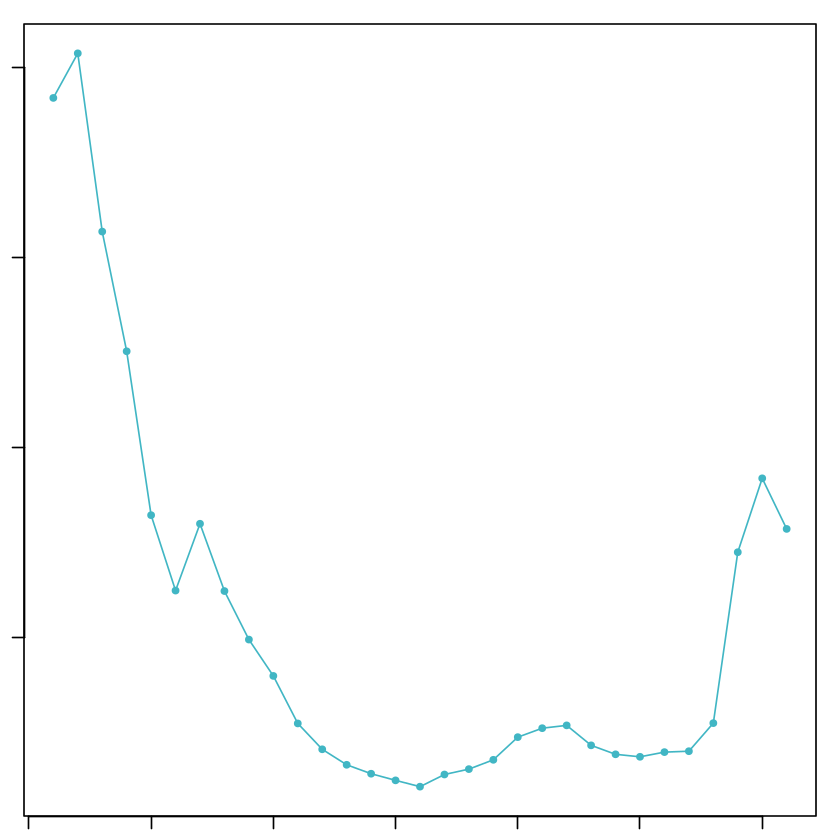

In [4]:
# Plotting for cell cycle scores
##### seeing the object formed for cell cycle scores ####
#head(dat_seurat_obj_filtered[[]])
#str(dat_seurat_obj_filtered)
#Getting Cell cycle scores from the seurat object 
S_score <- dat_seurat_obj_filtered@meta.data$S.Score
g2m_score <- dat_seurat_obj_filtered@meta.data$G2M.Score
cluster_info <- as.numeric(as.character(dat_seurat_obj_filtered@meta.data$seurat_clusters))
Phase <- dat_seurat_obj_filtered@meta.data$Phase
# View(S_score)
# View(g2m_score)
# View(cluster_info)
# View(Phase)
# making dataframe by combining relative stuff what we want to show in plot
cell_df <- cbind(cluster_info, Phase, g2m_score, S_score)

## converting to dataframe and calculating the percentage for stacked bar plot 
# link - https://rpubs.com/techanswers88/stackedbarcharts
cell_df <- data.frame(cell_df)
dt <- cell_df%>%
  dplyr::group_by(cluster_info, Phase)%>%
  dplyr::tally()%>%
  dplyr::mutate(percent=n/sum(n))

## plotting the result 
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_stack(vjust=0.5), colour="white", size = 2)


# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 ))
# pl
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/cell_cycle.jpg", width = 2000, height = 1200, res=300)
# pl <- ggplot(data = dt,aes(x= cluster_info, y = n,fill = Phase))
# pl <- pl + geom_bar(stat="identity", position ="fill")
# pl <- pl + geom_text(aes(label=paste0(sprintf("%1.1f", percent*100),"%")),
#                      position=position_fill(vjust=0.5), colour="black", size =3)

# pl <- pl + theme_minimal()
# #pl <- pl + labs(title ="Cell cycle score for SCAF2229")
# #pl <- pl + labs(subtitle ="plot")
# pl <- pl + labs(caption ="Cell cycle score for SCAF2326")
# pl <- pl  + labs(x ="Cluster", y = "Percentage")
# pl <- pl  + theme(axis.text.x = element_text(angle = 90,hjust =0 )) + coord_flip()
# pl
# dev.off()

### cell cycle plot without percent label
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/cell_cycle_SCAF2326.jpg", width = 2000, height = 1200, res=300)
# ggplot(dt, aes(x = cluster_info, y = percent, fill = Phase))+
#   geom_col()
# dev.off()
### we finished with data pre-processing prior to any doublet finder --- Now we can go for doublet finder 
### Important points - 1. Doublet finder needs to be done on each sample separately, prior to aggregating 
## pk identification --- no ground truth approach
# link -- https://rdrr.io/github/chris-mcginnis-ucsf/DoubletFinder/man/doubletFinder_ParamSweep.html
# link - https://www.youtube.com/watch?v=NqvAS4HgmrE
## required packages 
#install.packages("remotes")
#remotes::install_github("chris-mcginnis-ucsf/DoubletFinder", force=TRUE)
#library(DoubletFinder)

## step 13. Doublet Finding
sweep.list_SCAF3163 <- paramSweep_v3(dat_seurat_obj_filtered, PCs =1:20, sct=FALSE)
sweep.stats_SCAF3163 <- summarizeSweep(sweep.list_SCAF3163, GT = FALSE)
bcmvn_SCAF3163 <- find.pK(sweep.stats_SCAF3163)

### plotting the results --- highest value in plot is your optimal pK
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/optimal_k.jpg", width = 3000, height = 2000, res=300)
#ggplot(bcmvn_SCAF3163, aes(pK, BCmetric, group=1))+
#geom_point()+
#geom_line()
#dev.off()


### storing the highest pk value to a pk variable
pK <- bcmvn_SCAF3163 %>%
      filter(BCmetric == max(BCmetric)) %>%
      select(pK)
pK <- as.numeric(as.character(pK[[1]]))


### Homotypic doublet proprotion estimation
annotations <- dat_seurat_obj_filtered@meta.data$seurat_clusters
homotypic.prop <- modelHomotypic(annotations)
nExp_poi <- round(0.076*nrow(dat_seurat_obj_filtered@meta.data))
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))


#### run Doubletfinder 
dat_seurat_obj_filtered <- doubletFinder_v3(dat_seurat_obj_filtered, PCs = 1:20, pN = 0.25, pK = pK, nExp = nExp_poi.adj, reuse.pANN = FALSE, sct = FALSE)
## Viewing data frame 
View(dat_seurat_obj_filtered@meta.data)

In [5]:
# before plotting we need to see following items in our data
names(dat_seurat_obj_filtered@meta.data)
# from there we got the DF.classification, which we need for plot
# homotypic.prop
nExp_poi ## number of expected doublets
nExp_poi.adj ## number of actual doublets

[1] "orig.ident"                       "nCount_RNA"                      
 [3] "nFeature_RNA"                     "percent.mt"                      
 [5] "S.Score"                          "G2M.Score"                       
 [7] "Phase"                            "old.ident"                       
 [9] "CC.Difference"                    "RNA_snn_res.1"                   
[11] "seurat_clusters"                  "pANN_0.25_0.01_167"              
[13] "DF.classifications_0.25_0.01_167"

[1] 182

[1] 167

In [6]:
### visulaize the doublets 
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/doublets.jpg", width = 3000, height = 2000, res=300)
#DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_167")
#dev.off()

## Step 13. Doublets removal
#since we have the name doublets in one of our meta data column of a "dat_seurat_obj_filtered@meta_data", this column has singlet and doublet information
#we can only select singlet by specifying values and so
#Link --- https://nbisweden.github.io/workshop-scRNAseq/labs/compiled/seurat/seurat_01_qc.html
#data.filt = data.filt[, data.filt@meta.data[, DF.name] == "Singlet"]
data.filt = dat_seurat_obj_filtered[, dat_seurat_obj_filtered@meta.data[, "DF.classifications_0.25_0.01_167"] == "Singlet"]
#dim(data.filt)

### ploting the doublet removed dataset for PC & UMAP
#png("/data/kumarr9/scRNA/scRNA_results/SCAF3163/UMAP_doublets_removed.jpg", width = 3000, height = 2000, res=300)
#DimPlot(data.filt, reduction = "umap", label = TRUE, group.by = "DF.classifications_0.25_0.01_145")
#dev.off()


### plotting the doublet removed dataset with cluster info 
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/without_doublets.jpg", width = 3000, height = 2000, res=300)
# DimPlot(data.filt, reduction = "umap", label = TRUE)
# dev.off()



In [7]:
## step 14. Finding differentially expressed features (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
dat_filt.markers <- FindAllMarkers(data.filt, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)
# saving all the markers genes
# write.csv(dat_filt.markers, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_positive_marker_gene.csv")
# # saving markers genes for a defined crieria
# sub_df <- subset(dat_filt.markers, avg_log2FC > 2 & p_val < 0.05)
# write.csv(sub_df, file="/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_positive_marker_gene_significant.csv")
# # plotting the marker gene 
# png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/top5_markers.jpg", width = 5500, height = 3300, res=300)
# dat_filt.markers %>%
#     group_by(cluster) %>%
#     top_n(n = 5, wt = avg_log2FC) -> top5
# DoHeatmap(data.filt, features = top5$gene) + NoLegend()
# dev.off()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.844316e-164,3.163962,0.671,0.068,4.832478e-160,0,TUBB2B
9.803979e-175,3.125264,0.740,0.083,2.568839e-170,0,EEF1A2
5.126630e-141,4.033676,0.483,0.031,1.343280e-136,1,CCR7
4.050801e-152,3.595616,0.722,0.109,1.061391e-147,1,IL7R
3.006821e-93,4.067210,0.264,0.007,7.878472e-89,2,ZNF683
2.464459e-176,3.812774,0.639,0.040,6.457375e-172,2,CD8B
0.000000e+00,6.107374,0.834,0.013,0.000000e+00,3,FOXP3
2.288289e-214,4.740943,0.839,0.074,5.995774e-210,3,TNFRSF4
2.385405e-105,4.601614,0.370,0.018,6.250239e-101,4,RETN


In [10]:
Idents(data.filt)<- data.filt$seurat_clusters
# NEEDS TO BE FIXED AND SET ORDER CORRECTLY

In [12]:
Idents(data.filt) <- factor(Idents(data.filt), 
                       levels = c("0", "1", "2", "3", 
                                                "4", "5","6", 
                                                "7", "8", "9", "10", 
                                                "11", "12", "13", "14", "15", "16"))

Warning message:
“The following requested variables were not found: CD87, uPAR, CD90, CD133, CD166, ESA, PODXL1, PTCH, ALDH, OCT4”


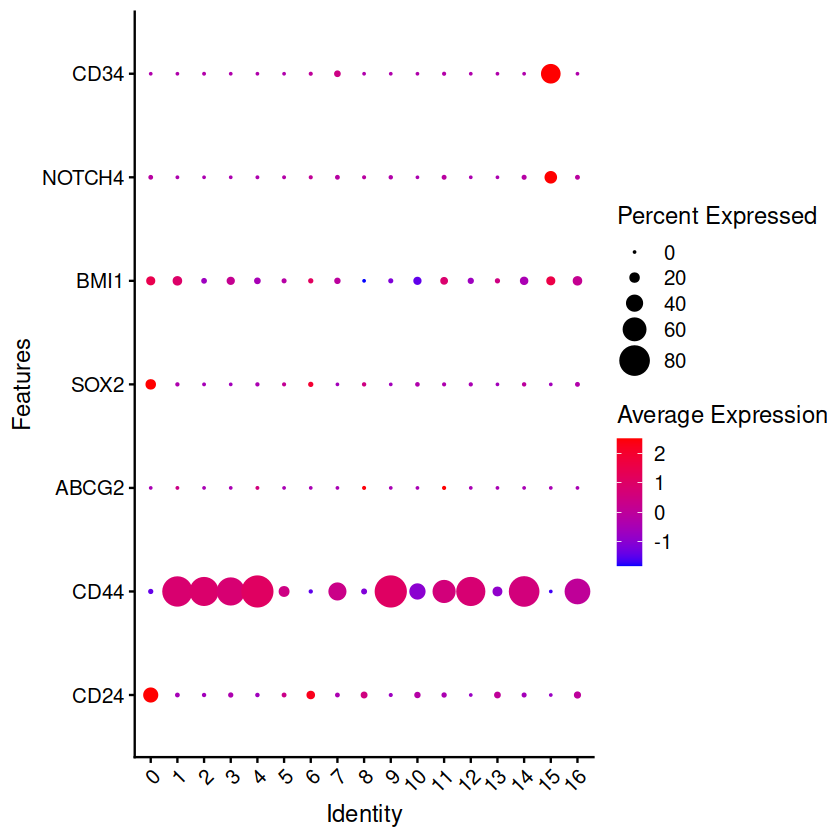

In [51]:
# stem cell markers which are used in box plot, filename is "Archetype_tuft_stem_cell_sgnature"
#markers.to.plot <- c("AKR1B1","NOTCH4","TMEM237","SAMD5","PKD2","NAP1L1","PTTG1","CDK6","CDCA7","ACSL4","HELLS","IKBIP","PMEM201","CACHD1","ILF3","DNMT1","USP31","FAM216A","SLC41A1","PFKM","KANK1","SUPT16H","ADCY3","FGD1","PTPN14","C200rf27","LGR6","SLC16A7","JAM3","FBL","NASP","RANBP1","PRNP","DSE","GPX7","KDELC1","FCHSD2","SLCO3A1","CCNB1IP1","LOC284023","NOL9","NKRF","NUP107","RCC2","ARHGAP25","DDX46","TCOF1","GMPS")
# stem cell markers from Ajit
markers.to.plot <- c("CD24","CD44","CD87","uPAR","CD90","CD133","CD166","ESA","ABCG2","PODXL1","PTCH","ALDH","SOX2","OCT4","BMI1", "NOTCH4", "CD34")


DotPlot(data.filt, features = markers.to.plot, cols = c("blue", "red"), 
        dot.scale = 08) +
        RotatedAxis()+ coord_flip()

In [ ]:
### for stemness as suggested by Vishaka extract/subset the tumor cluster only and then do all preprocessing again and run cytotrace

In [2]:
SCAF2326 <- readRDS("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/SCAF2326_cell_cycle_regress_difference_out_resolution_1.rds")

In [4]:
SCAF2326[[]]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.01_167,DF.classifications_0.25_0.01_167,neuro1,non_neuro1
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.0663570,0.062028806,-0.089463888,S,SCLC,0.151492694,0,0,0.06250,Singlet,0.051417977,-0.02918315
AAACCTGCATAACCTG-1,SCLC,3244,658,2.5893958,-0.059976841,-0.026566814,G1,SCLC,-0.033410027,5,5,0.03125,Singlet,0.074471569,0.28717677
AAACCTGCATTTCACT-1,SCLC,4083,1850,2.4246877,-0.022671791,-0.076830556,G1,SCLC,0.054158765,11,11,0.09375,Singlet,-0.101228492,-0.02556052
AAACCTGGTGACTCAT-1,SCLC,7704,2241,3.3878505,-0.062310283,-0.021173250,G1,SCLC,-0.041137033,1,1,0.06250,Singlet,-0.091507265,0.23900513
AAACCTGGTGGTAACG-1,SCLC,2060,1050,3.4951456,0.017646544,-0.166250278,S,SCLC,0.183896823,1,1,0.03125,Singlet,-0.078218817,0.35946853
AAACCTGGTTCGTTGA-1,SCLC,5017,1862,2.7307156,-0.035989169,-0.040630124,G1,SCLC,0.004640955,1,1,0.06250,Singlet,-0.103466956,0.12692335
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.6073992,0.070506773,0.003091556,S,SCLC,0.067415218,8,8,0.03125,Singlet,-0.025826358,-0.08811751
AAACGGGAGCCTCGTG-1,SCLC,2053,845,4.8222114,-0.008685183,-0.015908596,G1,SCLC,0.007223413,1,1,0.15625,Singlet,-0.067686545,0.07799662
AAACGGGGTCCAACTA-1,SCLC,4812,1830,4.2394015,-0.119019701,-0.153388476,G1,SCLC,0.034368775,1,1,0.03125,Singlet,-0.090701152,0.19200321


In [5]:
# extracting for tumor sample only
clusters_subset <- c(0, 6, 8)
SCAF2326_subset <- subset(SCAF2326, ident = clusters_subset)

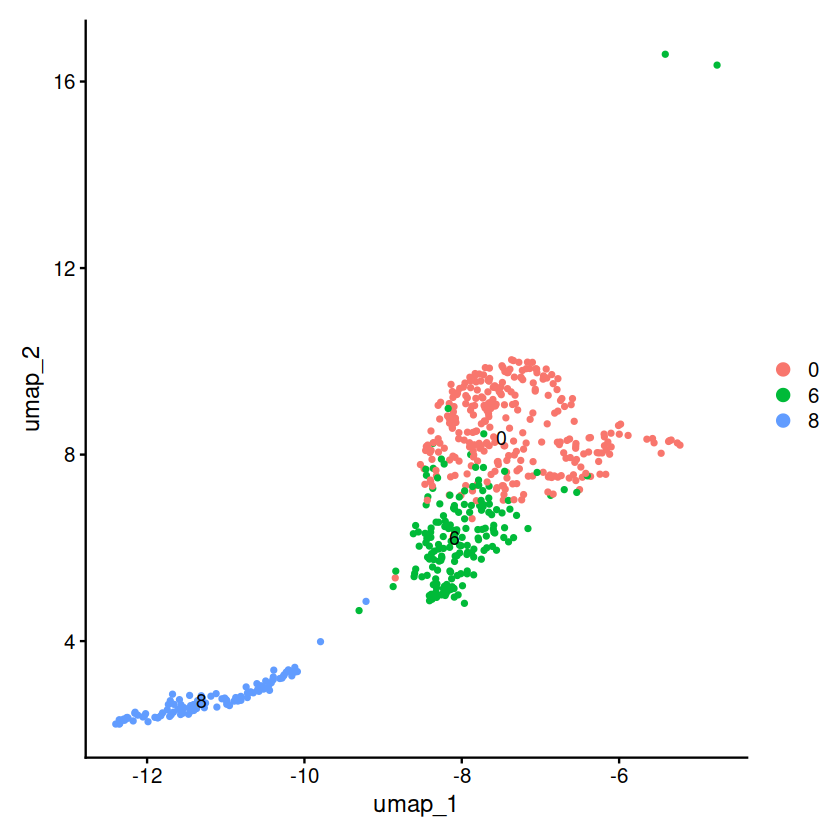

In [10]:
dat_seurat_obj_filtered <- NormalizeData(SCAF2326_subset)

Warning message:
“The following arguments are not used: nselect”
Warning message in PrepDR(object = object, features = features, verbose = verbose):
“The following 3 features requested have not been scaled (running reduction without them): MLF1IP, FAM64A, HN1”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
PC_ 1 
Positive:  GAS2L3, G2E3, CDC25C, ANLN, BRIP1, CDCA7, CHAF1B, CENPE, LBR, CDCA2 
	   RANGAP1, CBX5, CCNE2, TIPIN, HELLS, CTCF, CASP8AP2, CKAP2L, WDR76, DSCC1 
	   POLD3, RAD51AP1, NCAPD2, PRIM1, RAD51, RFC2, KIF20B, DLGAP5, TTK, CDCA3 
Negative:  TYMS, HMGB2, TUBB4B, TOP2A, UBE2C, CKS1B, NUSAP1, CKAP2, TPX2, CKS2 
	   NASP, SLBP, CCNB2, PCNA, RRM1, CDC20, FEN1, CDC45, UNG, MCM2 
	   GMNN, AURKA, KIF23, UHRF1, BIRC5, ATAD2, TMPO, CDK1, MCM5, ECT2 
PC_ 2 
Positive:  UBE2C, NEK2, BIRC5, AURKB, CKS1B, CDK1, TUBB4B, CKS2, RAD51AP1, HMGB2 
	   PRIM1, PSRC1, KIF20B, RRM2, TOP2

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 568
Number of edges: 29535

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8387
Number of communities: 2
Elapsed time: 0 seconds


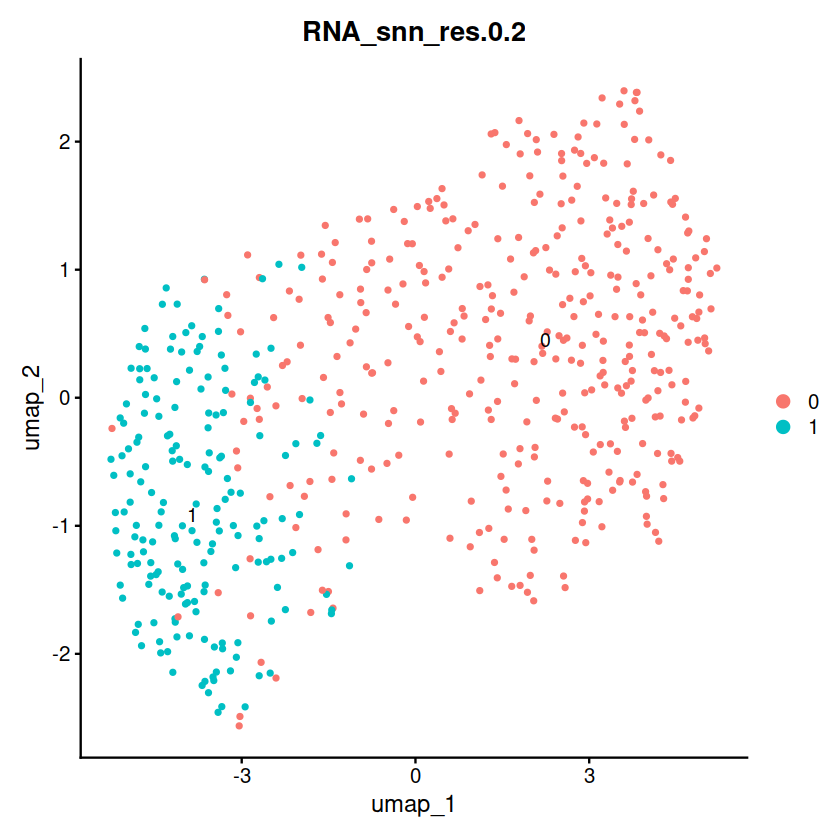

In [28]:
dat_seurat_obj_filtered <- FindVariableFeatures(dat_seurat_obj_filtered, selection.method = "vst")
#s.genes <- cc.genes$s.genes
#g2m.genes <- cc.genes$g2m.genes
#dat_seurat_obj_filtered <- CellCycleScoring(dat_seurat_obj_filtered, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)
### Regressing out cell cycle from the object ###
#dat_seurat_obj_filtered$CC.Difference <- dat_seurat_obj_filtered$S.Score - dat_seurat_obj_filtered$G2M.Score
#dat_seurat_obj_filtered <- ScaleData(dat_seurat_obj_filtered, vars.to.regress = "CC.Difference", features = rownames(dat_seurat_obj_filtered))
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2418/alternate_cell_cycle_regress_out/difference_regressed_cell_cyle_SCAF2418.jpg", width = 3000, height = 2000, res=300)
dat_seurat_obj_filtered <- RunPCA(dat_seurat_obj_filtered, features = c(s.genes, g2m.genes))

dat_seurat_obj_filtered <- FindNeighbors(dat_seurat_obj_filtered, dims = 1:20) ## can change dims according to your needs
dat_seurat_obj_filtered <- FindClusters(dat_seurat_obj_filtered, resolution = 0.2) ### here resolution (resolution = 0.5 or so) or like this wasy (resoultion=c(0.1, 0.3, 0.5, 0.7, 1)) can be added to see at what resolution your data fits ( resolution here means, how many clusters you want to see in your data, lower the number lower cluster anf higher the number higher clusters)
#View(dat_seurat_obj_filtered@meta.data)
DimPlot(dat_seurat_obj_filtered, group.by="RNA_snn_res.0.2", label=TRUE)
#Idents(dat_seurat_obj_filtered) <- "RNA_snn_res.1" ## setting increased resolution of cluster 
#dat_seurat_obj_filtered <- RunUMAP(dat_seurat_obj_filtered, dims = 1:20)
#png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2418/alternate_cell_cycle_regress_out/UMAP.jpg", width = 3000, height = 2000, res=300)
#DimPlot(dat_seurat_obj_filtered, reduction = "umap", label = TRUE)

In [27]:
dat_seurat_obj_filtered[[]]

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.1,seurat_clusters,pANN_0.25_0.01_167,DF.classifications_0.25_0.01_167,neuro1,non_neuro1,RNA_snn_res.0.2
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
AAACCTGAGATGTGGC-1,SCLC,3014,1367,0.06635700,-0.156680032,-0.36793091,G1,0,0.211250879,1,0,0.06250,Singlet,0.05141798,-0.0291831479,0
AAACCTGTCGGAAATA-1,SCLC,1811,207,0.60739923,0.025839423,-0.04894269,S,8,0.074782108,2,1,0.03125,Singlet,-0.02582636,-0.0881175110,1
AAAGATGAGAAGGTTT-1,SCLC,1742,226,2.12399541,-0.063990051,-0.08356444,G1,8,0.019574391,3,1,0.00000,Singlet,-0.02142777,0.0543605514,1
AAAGATGCATACAGCT-1,SCLC,5083,2143,0.60987606,-0.215311463,-0.31778023,G1,0,0.102468762,1,0,0.15625,Singlet,0.25140626,-0.2142867765,0
AAAGTAGAGACTTGAA-1,SCLC,3155,1613,1.83835182,0.391391553,-0.34873032,S,0,0.740121869,0,0,0.06250,Singlet,-0.04795150,-0.3047496812,0
AAATGCCCACGAAACG-1,SCLC,4265,1877,2.39155920,-0.249298342,0.43914172,G2M,0,-0.688440064,0,0,0.06250,Singlet,0.05363526,0.0707644036,0
AACACGTGTGTTGGGA-1,SCLC,1115,820,2.51121076,-0.070702816,0.01061391,G2M,0,-0.081316729,1,0,0.06250,Singlet,-0.07146960,-0.0662818878,0
AACCATGTCCTCAATT-1,SCLC,2319,1421,0.56058646,0.102555427,0.20934167,G2M,0,-0.106786240,0,0,0.00000,Singlet,-0.03649160,-0.0986710853,0
AACCATGTCTGGTGTA-1,SCLC,5457,2190,0.84295400,-0.012883917,-0.29861675,G1,0,0.285732834,0,0,0.15625,Singlet,0.29032787,-0.2732989560,0


In [13]:
dat_filt.markers <- FindAllMarkers(dat_seurat_obj_filtered, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
dat_filt.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
4.101633e-18,2.597758,0.298,0.039,1.074710e-13,0,KIF23
4.825346e-27,2.595223,0.498,0.091,1.264337e-22,0,UBE2C
9.460701e-05,1.322291,0.306,0.171,1.000000e+00,1,DPYSL3
2.078888e-04,1.190135,0.300,0.173,1.000000e+00,1,URI1
2.518595e-04,1.153173,0.328,0.193,1.000000e+00,2,SLC25A37
9.524186e-05,1.130132,0.423,0.255,1.000000e+00,2,HBB
1.143986e-36,3.949151,0.446,0.020,2.997473e-32,3,SLC4A1
7.296145e-38,3.776195,0.679,0.076,1.911736e-33,3,ALAS2


In [15]:
library(CytoTRACE)

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”


Warning message:
“The following arguments are not used: scale.factor”
Centering and scaling data matrix

The number of cells in your dataset is less than 3,000. Fast mode has been disabled.

CytoTRACE will be run on 1 sub-sample(s) of approximately 568 cells each using 1 / 1 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



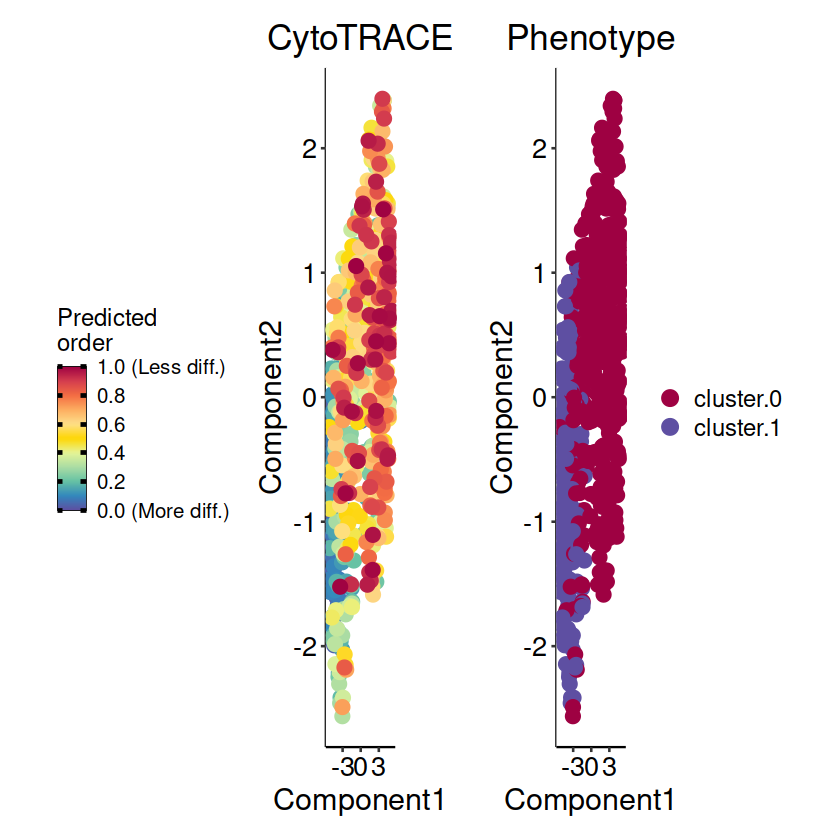

In [29]:
seurat_obj <- ScaleData(dat_seurat_obj_filtered, scale.factor=1e6)
mtrx <- FetchData(seurat_obj, vars=rownames(seurat_obj))
mtrx <- t(mtrx)
genes.w.reads <- names(rowSums(mtrx)[rowSums(mtrx)>0])
 mtrx <- mtrx[genes.w.reads,]

 mtrx <- data.frame(mtrx)
 mtrx[mtrx=='.'] <- 0

# ##  outputs a list that includes CytoTRACE score per cell
 Cytotrace.out <- CytoTRACE(mtrx)

 meta <- paste0('cluster.', seurat_obj$seurat_clusters)
 names(meta) <- colnames(seurat_obj)
 names(meta) <- str_replace(names(meta), '-', '.')

# ## UMAP embeddings from Seurat
 umap.embeddings <- as.data.frame(seurat_obj[["umap"]]@cell.embeddings)
 row.names(umap.embeddings) <- str_replace(row.names(umap.embeddings), '-', '.')
cytotrace.plots <- plotCytoTRACE(Cytotrace.out, emb = umap.embeddings, phenotype = meta, outputDir = '/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/CytoTRACE.output.data')

In [30]:
saveRDS(seurat_obj, file = "/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/SCAF2326tumor_subsetted.rds")

In [48]:
## module score analysis 
## Stem cell gene signature
sclc_ne_genes <- c("ABI3BP","ACER2","ACTA2","ACTG2","ACVR2A","ADAMTS1","ADAMTS2","ADARB1","AEBP1","AGPAT4","AHI1","AKAP2","AKT3","ALDH1L2","AMOTL1","ANGPTL2","ANKRD1","ANTXR1","APOE","AQP9","ARC","ARHGAP20","ARHGAP24","ARHGAP25","ARHGEF25","ARNTL","ARSI","ASPHD2","ATP2A2","AXL","BACH1","BAG3","BCAR1","BCL2L11","BCOR","BMP1","BMP7","BNC1","BTBD11","BVES","C10orf54","C12orf24","C13orf33","C14orf149","C14orf37","C17orf81","C19orf12","C1QTNF4","C21orf7","C2orf40","C3orf54","C3orf58","C3orf64","C4orf49","C5orf25","C6orf145","C6orf228","C8orf84","C9orf3","CACNB4","CADM1","CALD1","CALML3","CALU","CARD10","CAV1","CBLB","CCDC3","CCDC85B","CCND2","CD36","CD70","CDC42EP2","CDH13","CDH3","CDH4","CDKN1A","CHST3","CHST7","CHSY3","CLIP3","CLMP","CNN1","CNP","CNRIP1","COL12A1","COL14A1","COL16A1","COL17A1","COL18A1","COL23A1","COL4A1","COL4A2","COL5A1","COL5A2","COL7A1","COL9A2","CPNE8","CPXM1","CRISPLD1","CRLF1","CRYAB","CSDC2","CSPG4","CSRP2","CTGF","CTNNAL1","CXCL14","CYGB","D4S234E","DCBLD2","DCHS1","DCUN1D3","DKK3","DLK2","DLL1","DMWD","DOCK10","DPYSL3","DST","DUSP6","DUSP7","DZIP1L","EBF3","EDARADD","EDNRB","EEPD1","EFCAB1","EFNB1","EGFR","EGR2","EGR3","EID3","ELK3","ELOVL4","ENC1","ENPP2","EPAS1","EPDR1","EPHB1","ERF","ETS1","ETV5","EVC","EXT1","FABP5","FAM101B","FAM132A","FAM176A","FAM184A","FAM70B","FAS","FBLN1","FBLN7","FBXO30","FERMT2","FEZ1","FGFRL1","FGL2","FHL1","FHOD3","FJX1","FLNC","FLRT2","FMOD","FOXP1","FST","FXYD1","FZD8","GEM","GJA1","GJC1","GNAI1","GNB4","GNG11","GOLIM4","GPC3","GPR124","GPR176","GPR3","GPR87","GPSM1","GRASP","GSN","GYLTL1B","GYPC","HAS2","HDAC4","HEG1","HGFAC","HRAS","HS3ST3A1","HSPB2","HSPG2","HTRA1","ICAM1","ID4","IGFBP2","IGFBP3","IGFBP4","IGFBP6","IL17B","IL17RD","IL1B","IL24","IL6","IL6ST","IRX4","ISM1","ITGA1","ITGA6","ITGA9","ITGB1","ITGB4","ITM2A","JAG1","JAM2","JAM3","KANK4","KCNIP3","KCNMA1","KCNMB1","KDELC1","KIAA0889","KLHDC5","KLHL21","KLHL29","KRT14","KRT16","KRT5","KRT75","LAG3","LAMA1","LAMA3","LAMB1","LAMB3","LAMC1","LBH","LCA5","LCAT","LEP","LEPRE1","LEPREL1","LGALS1","LGALS7","LGR6","LHFP","LIFR","LIMA1","LIMS2","LMOD1","LPHN1","LRCH2","LRP1","LRP4","LRRC8C","LRRN1","LTBP4","LUZP1","MALT1","MAMDC2","MAOB","MATN2","MBNL1","MCAM","MEF2C","MEG3","MEST","MFNG","MIA","MICAL2","MME","MMP2","MPDZ","MRGPRF","MRVI1","MSRB3","MSX1","MTSS1","MXRA7","MYC","MYH11","MYL9","MYLK","MYOCD","NBL1","NDN","NETO2","NGF","NGFR","NLGN2","NNAT","NNMT","NPTX2","NRCAM","NRG1","NRP1","NRP2","NT5E","NTF3","NTRK2","NUDT10","NUDT11","NXN","ODZ3","OSBPL6","OSR1","OXTR","PAMR1","PARD6G","PCBP4","PCDH18","PCDH19","PCDH7","PCDHGC3","PCOLCE","PDGFA","PDLIM4","PDLIM7","PDPN","PEG3","PELO","PGF","PHLDA3","PHLDB1","PKD1","PKD2","PKNOX2","PKP1","PLA2G7","PLCH2","PLEKHA4","PLS3","PLXNA2","PODN","POPDC2","POSTN","POU3F1","PPAP2A","PPAP2B","PPP1R14A","PPP1R16B","PPP1R18","PPP1R3C","PPP2R2B","PRDM1","PRICKLE1","PRICKLE2","PRNP","PROS1","PRRX1","PRX","PSD2","PTGS2","PTPLA","PTPRE","PTPRT","PVRL3","PXN","QKI","QRICH2","RAB34","RAPGEF1","RARB","RARRES2","RASIP1","RASL12","RBPMS","RCN3","RCSD1","RECK","RELN","RFX2","RGNEF","RHOJ","RND3","RNF165","RUSC2","SCARF2","SCHIP1","SCML2","SCN4B","SDK2","SDPR","SEC24D","SEMA3C","SEMA5A","SERPINF1","SERPING1","SERPINH1","SGCB","SGIP1","SH2D5","SH3TC1","SHE","SIAH2","SKI","SLC12A4","SLC1A3","SLC1A5","SLC25A4","SLC27A3","SLC27A6","SLC2A3","SLC38A5","SLC4A3","SLC6A8","SLCO3A1","SLIT2","SLIT3","SMTN","SNAI2","SNCA","SNTB2","SOBP","SORBS1","SORCS1","SOX11","SPARC","SPHK1","SPRED1","SRGN","SRPX","SSBP2","SSH1","STAC","STAC2","STARD8","STXBP4","SULF1","SVEP1","SYDE1","SYNM","TACC1","TAGLN","TBX2","TCF4","TCF7L1","TCOF1","TES","TGFB1I1","TGFBR3","THBS1","THSD1","THY1","TIE1","TIMP3","TINAGL1","TM7SF3","TMEM121","TMEM178","TMEM201","TMEM204","TMEM47","TMEM64","TNS1","TNS4","TOX","TP63","TPM2","TPST1","TRIM29","TRIM9","TRO","TRPC1","TSHZ2","TSHZ3","TSKU","TSPY26P","TSPYL2","TTL","TTYH2","TUBB6","TWIST2","UCN2","UNC45A","UPP1","VCAN","VGLL3","VIM","VIT","VSNL1","WIF1","WIPF1","WTIP","YAF2","ZC3H12B","ZNF219","ZNF423")
#sclc_ne_genes <- c("SPIC","HIST1H1A","TFAP2B","VIM","SPIB","CEBPA","MGP","TPM2","RASD2","PAPSS2","CD44","COL3A1","AHNAK","IGFBP3","RPSA","HSP90AB1","RPL32","DTX4","KRT7","RPL26","GSN","NFKB2","STOM","CPE","SIX2","BCL7B","PTPRN2","CPLX2","CXXC4","SEZ6L2","MYT1","ID4","UCKL1","SYT4","MRAP2","ATP2B3","ANKRD24","ABLIM2","MT-CO1","MT-ATP6","UNC80","VAMP2","PON3","MYADM","PCDHA10","SV2B","ACTL6B","PLBD2","POU2F2","RFX2","LSAMP","PHYHIPL","DPYSL4","RNF224","NRXN1","UNC13A","PRIMPOL","ZFPM1","GTPBP3","SLC7A14","SYT7","HOXB2","FAM13C","PCBP3","MAPT","SGSM1","USB1","MT-ND3","GAD2","PSD","PTPRN","MT-CO2","SLC18A1","NRG1","NRSN1","MT-ATP8","GPR68","TRIM9","HSD11B1L","ENTPD2","CHGA","LMO2","PCDHAC1","STH","HRH3","MT-ND4L","DLK1","TEX15","ANO4","SHC2","MT-ND2","GRM8","FLRT1","LRRC36","SRRM3","CNR1","CRYBA2","PCDHA13","FBN3","ADAMTSL2","FAM163B","FAM155A","PCDHA5","DUSP26","FOXA2","GABRB3","CDHR2","FMN2","RGS7","STAP2","TSHZ2","DBH","GRM2","MT-CYB","SEZ6L","FAM19A5","RBFOX1","MT-ND4","KCNT2","PEG10","SLC38A10","ATP8A2","KCNH5","MPPED1","PCBD2","SCIN","RHOBTB2","NLGN1","KCNK17","ST8SIA3","PCDHA4","LRFN5","TMEM88B","FAM95C","FSCN2","POU3F3","KCNK16","LHFPL4","NCALD","ADARB2","BARHL1","SLC35F3","CDK5R2","PNMA6A","COX19","ADCYAP1","MT-ND5","VGF","GLB1L3","AMPH","CAMK2N1","NGB","TMPRSS6","ADAP1","HBA1","HBA2")
#sclc_non_ne_genes <- c("ABCC3", "AHNAK", "ANXA1", "ARHGDIB", "CAV1","CAV2", "CCND1", "CYR61", "EMP1", "EPHA2",
#                        "IFITM2", "IFITM3", "ITGB4", "LGALS3", "MYOF","PLAU", "PTGES", "RAB27B", "S100A10", "S100A16",
#                        "SLC16A5", "TACSTD2", "TGFBI", "TGFBR2", "YAP1")
seurat_obj <- AddModuleScore(object = seurat_obj, 
                                   features = list(sclc_ne_genes),
                                   ctrl = 20,
                                   name = "stem"
                                   )

# seurat_obj <- AddModuleScore(object = seurat_obj, 
#                                    features = list(sclc_non_ne_genes),
#                                    ctrl = 20,
#                                    name = "non_neuro"
#                                    )
gene_data <- seurat_obj@meta.data$neuro1
cluster_info <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info <- as.numeric(cluster_info)
data_df <- cbind(gene_data, cluster_info)
data_df <- as.data.frame(data_df)
#data_df <- data.frame(gene_data, cluster_info)
# Set the plot title and y-axis label


#gene_data2 <- seurat_obj@meta.data$non_neuro1
#cluster_info2 <- as.numeric(as.character(seurat_obj@meta.data$seurat_clusters))
#cluster_info2 <- as.numeric(cluster_info2)
#data_df2 <- cbind(gene_data2, cluster_info2)
#data_df2 <- as.data.frame(data_df2)
#data_d2f <- data.frame(gene_data2, cluster_info2)

## Plotting starts from here 
ne <- ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, fill= factor(cluster_info))) +
  geom_violin() + stat_summary(fun.data="mean_sdl", mult=1, 
                 geom="crossbar", width=0.2 ) +
  labs(x = "Cluster", y = "Expression") + theme_minimal() + 
  ggtitle("stemness gene expression Cluster")
 ne1 <- ne + theme(legend.position = "none") ## added to remove the fill label
#  non_ne <- ggplot(data_df2, aes(x = factor(cluster_info2), y = gene_data2, fill= factor(cluster_info2))) +
#     geom_violin() +
#     labs(x = "Cluster", y = "Expression") + theme_minimal() + 
#     ggtitle("Non-NE gene expression by Cluster") + geom_hline(yintercept=0.00, linetype="dashed", color = "red")
# non_ne1 <-  non_ne + theme(legend.position = "none") ## added to remove the fill label
png("/data/kumarr9/scRNA/atac.scRNA.parth/SCAF2326/alternate_cell_cycle_regress_out/infercnv_result_1_10_1/module_score_signature_genes.jpg", width = 1000, height = 800, res=300)
ggarrange(ne1,
          ncol = 1, nrow = 1)
dev.off()

Warning message:
“The following features are not present in the object: SPIC, STH, FAM19A5, FAM95C, KCNK16, BARHL1, not searching for symbol synonyms”
Warning message in stat_summary(fun.data = "mean_sdl", mult = 1, geom = "crossbar", :
“Ignoring unknown parameters: `mult`”


png 
  2

Warning message in stat_summary(fun.data = "mean_sdl", mult = 1, geom = "crossbar", :
“Ignoring unknown parameters: `mult`”
Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”


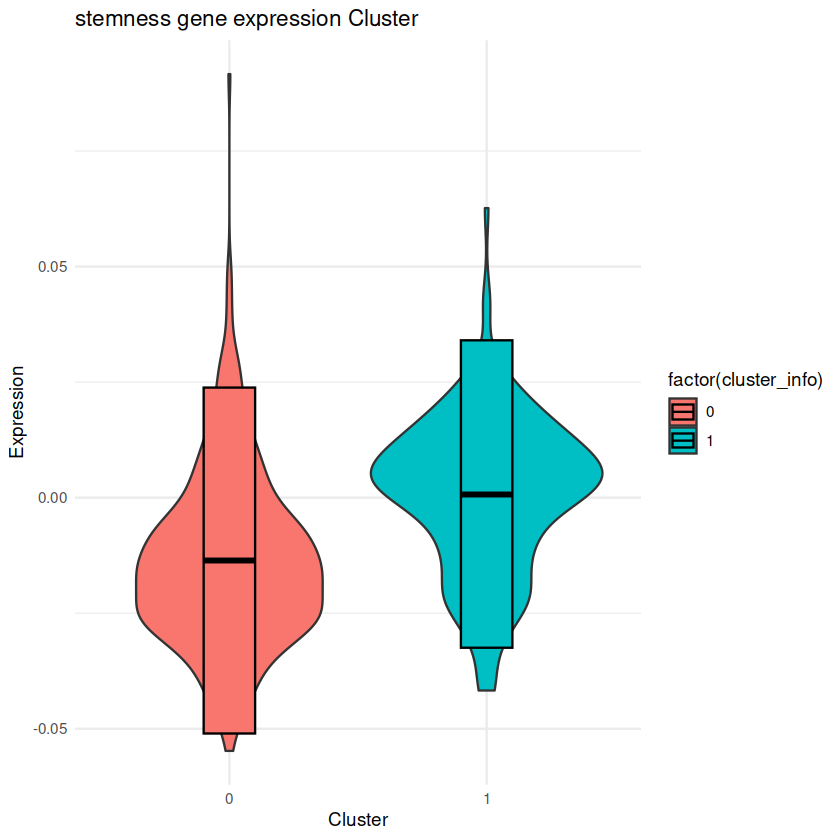

In [45]:
library(ggpubr)

ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, fill = factor(cluster_info))) +
  geom_violin() +
  stat_summary(fun.data = "mean_sdl", mult = 1, geom = "crossbar", width = 0.2) +
  labs(x = "Cluster", y = "Expression") +
  theme_minimal() +
  ggtitle("stemness gene expression Cluster") +
  stat_compare_means(comparisons = list(c("cluster1", "cluster0")), method = "t.test", label = "p.signif")


Warning message:
“Computation failed in `stat_signif()`
Caused by error in `if (scales$x$map(comp[1]) == data$group[1] | manual) ...`:
! missing value where TRUE/FALSE needed”


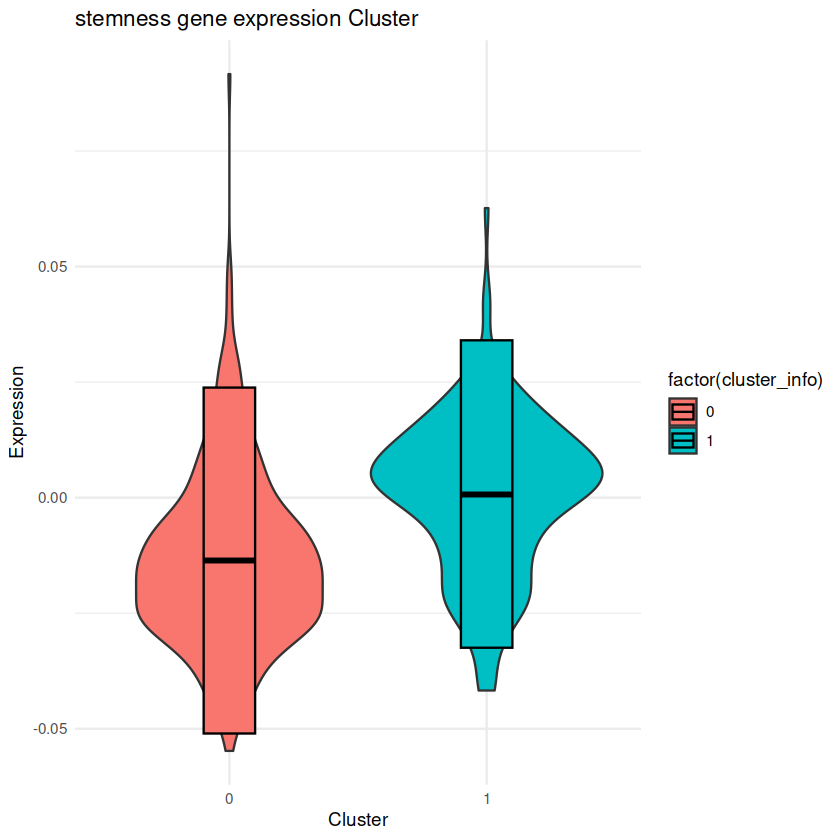

In [46]:
library(ggpubr)

ggplot(data_df, aes(x = factor(cluster_info), y = gene_data, fill = factor(cluster_info))) +
  geom_violin() +
  stat_summary(fun.data = "mean_sdl", geom = "crossbar", width = 0.2) +
  labs(x = "Cluster", y = "Expression") +
  theme_minimal() +
  ggtitle("stemness gene expression Cluster") +
  geom_signif(comparisons = list(c("cluster1", "cluster0")), map_signif_level = TRUE)
